# **1. Importing Library**

In [23]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **2. Preparing Dataset**

In [2]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import splitfolders 
splitfolders.ratio("/kaggle/input/agronify-dataset/RipenessFruits/Ripeness/Pisang", 
                   output="Banana-data", 
                   seed=42, 
                   ratio=(.7, .2,.1), 
                   group_prefix=None) 


Copying files: 13478 files [01:40, 133.93 files/s]


In [4]:
training_dir = os.path.join('Banana-data', 'train')
testing_dir = os.path.join('Banana-data', 'test')
validating_dir = os.path.join('Banana-data', 'val')

# **3. Data Preprocessing**

In [5]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 9433 images belonging to 4 classes.
Found 2694 images belonging to 4 classes.
Found 1351 images belonging to 4 classes.


In [6]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)

{'overripe': 0, 'ripe': 1, 'rotten': 2, 'unripe': 3}
['overripe', 'ripe', 'rotten', 'unripe']


# **4. Data Preview**

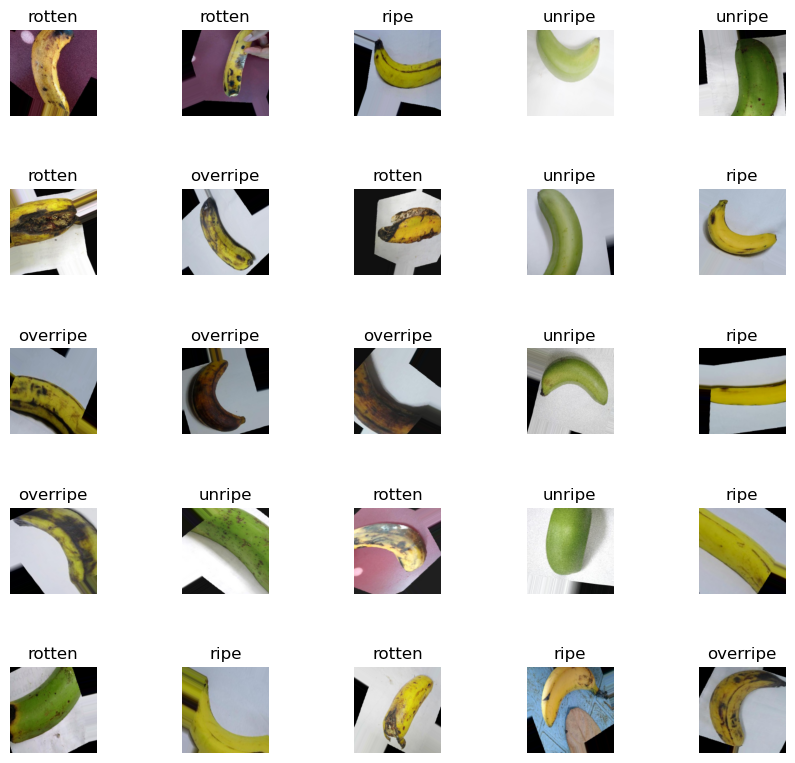

In [7]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

# **5. Callbacks Function**

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('You entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.total_epochs:
                        print('\nYou specified a maximum of', self.total_epochs, 'epochs. Cannot train for', self.ask_epoch, flush=True)
                    else:
                        print('You entered', ans, 'Training will continue to epoch', self.ask_epoch, flush=True)
                        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current learning rate is {current_lr:7.5f}.')

# **6. Selecting Model**

In [14]:
tf.keras.backend.clear_session()
del model

In [20]:
IMAGE_CHANNEL = 3
IMAGE_SIZE = 224

model_name = 'MobileNetV3Small'
input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet',
                                                   pooling='max')

base_model.trainable = True


# **7. Creating Architecture Model**

In [24]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128,
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.01),
          bias_regularizer=regularizers.l1(0.01),
          activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

# **8. Training Model**

In [25]:
total_epochs = 50
ask_epoch = 30
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
callbacks = [rlronp_callback, ask_callback]

# **9. Model Validation**

In [26]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             shuffle=False,
                             initial_epoch=0)

Training will proceed until epoch 30 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/50
295/295 [==============================] - ETA: 0s - loss: 1.6289 - accuracy: 0.8442
Validation loss of  2.0419 is below the lowest loss, saving weights from epoch 1   as the best weights
295/295 [==============================] - 201s 411ms/step - loss: 1.6289 - accuracy: 0.8442 - val_loss: 2.0419 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 2/50
295/295 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.9540
Validation loss of  2.3491 is above the lowest loss of  2.0419, keeping weights from epoch 1 as the best weights
295/295 [==============================] - 120s 406ms/step - loss: 0.4676 - accuracy: 0.9540 - val_loss: 2.3491 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 3/50
295/295 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.9598
Epoch 3: ReduceLROnPlateau reducing lear

 20


You entered 20 Training will continue to epoch 50
Current learning rate is 0.00002.
295/295 [==============================] - 165s 559ms/step - loss: 0.0875 - accuracy: 0.9952 - val_loss: 0.4370 - val_accuracy: 0.8801 - lr: 1.5625e-05
Epoch 31/50
295/295 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9951
Epoch 31: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Validation loss of  0.2714 is above the lowest loss of  0.1017, keeping weights from epoch 25 as the best weights
295/295 [==============================] - 119s 404ms/step - loss: 0.0864 - accuracy: 0.9951 - val_loss: 0.2714 - val_accuracy: 0.9280 - lr: 1.5625e-05
Epoch 32/50
295/295 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9961
Validation loss of  0.1353 is above the lowest loss of  0.1017, keeping weights from epoch 25 as the best weights
295/295 [==============================] - 120s 408ms/step - loss: 0.0843 - accuracy: 0.9961 - val_loss: 0.1353 

 H


You entered H Training halted on epoch 50 due to user input

295/295 [==============================] - 136s 462ms/step - loss: 0.0839 - accuracy: 0.9955 - val_loss: 0.0899 - val_accuracy: 0.9933 - lr: 4.8828e-07
Loading model with weights from epoch 43
Training elapsed time was 1.0 hours, 48.0 minutes, 1.69 seconds)


# **10. Model Evaluation**

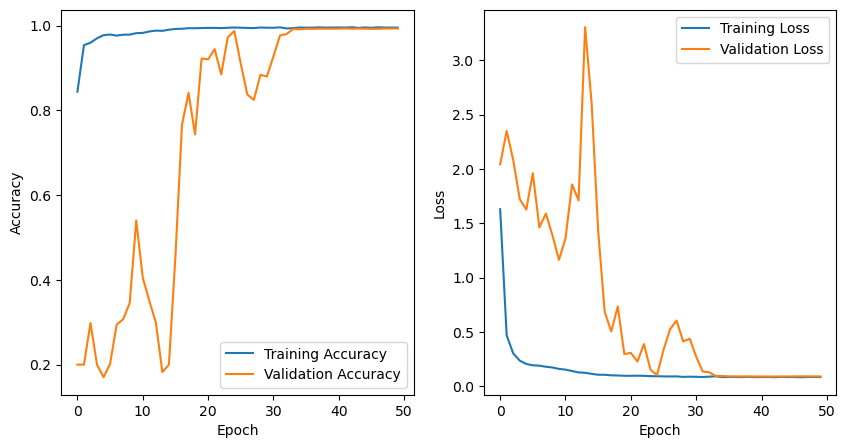

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

43/43 [==============================] - 4s 85ms/step - loss: 0.0888 - accuracy: 0.9926
Test loss: 0.0887848287820816 / Test accuracy: 0.9925980567932129


# **11. Prediction Test**

# **12. Save Model**

In [32]:
model.save('pisangMobileNetv3Small.h5')